In [31]:
# !pip install keras2onnx  #For older tensorflow (up to 2.3.1)
!pip install tf2onnx  #For newer tensorflow (I tested on 2.4.4)
!pip install onnxruntime
!pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.3/442.3 KB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.8 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.1.21
    Uninstalling flatbuffers-23.1.21:
      Successfully uninstalled flatbuffers-23.1.21
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
Looking in indexes: https://pypi.org/simpl

In [1]:
!wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training.tif
!wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training_groundtruth.tif
# !wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/volumedata.tif
# !unzip 
#!wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/results_test.tif



--2023-02-26 04:43:39--  https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training.tif
Resolving documents.epfl.ch (documents.epfl.ch)... 128.178.222.197, 2001:620:618:1de:1:80b2:dec5:1
Connecting to documents.epfl.ch (documents.epfl.ch)|128.178.222.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129919357 (124M) [application/octet-stream]
Saving to: ‘training.tif’

training.tif         31%[=====>              ]  39.61M   938KB/s    eta 77s    ^C
--2023-02-26 04:44:15--  https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training_groundtruth.tif
Resolving documents.epfl.ch (documents.epfl.ch)... 128.178.222.197, 2001:620:618:1de:1:80b2:dec5:1
Connecting to documents.epfl.ch (documents.epfl.ch)|128.178.222.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129919357 (124M) [application/octet-stream]
Saving to: ‘training_groundtruth.tif’

training_g

In [1]:
!pip install multipagetiff
import multipagetiff as mtif # in order to make small patches out of big images, I used multipagetiff 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:

# you can either download data or import it from google drive
# mount it
from google.colab import drive
drive.mount('/content/drive')
# save the data on your google drive
!cp /content/drive/MyDrive/training.tif /content/
!cp /content/drive/MyDrive/training_groundtruth.tif /content/ 
!cp /content/drive/MyDrive/simple_unet_model.py /content/


# load the Data from google drive
img = mtif.read_stack("/content/training.tif", units='um')
msk = mtif.read_stack("/content/training_groundtruth.tif", units='um')

Mounted at /content/drive


In [3]:
!pip install patchify


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from simple_unet_model import simple_unet_model  #Our model saved in the accompanying python file
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff

In [5]:
#I saved 12 random images and corresponding masks into a tiff stack.
#Here, let us load the image and mask stacks.
# large_image_stack = tiff.imread('small_dataset_for_training/images/12_training_mito_images.tif')
large_image_stack = img[0:12,:,:]
# large_mask_stack = tiff.imread('small_dataset_for_training/masks/12_training_mito_masks.tif')
large_mask_stack = msk[0:12,:,:]

In [7]:
large_image_stack.shape

(12, 768, 1024)

In [6]:
#Divide images and masks into smaller patches (e.g., 256x256)
#You can use patchify library if you want
all_img_patches = []
for img in range(large_image_stack.shape[0]):
    #print(img)     #just stop here to see all file names printed
     
    large_image = large_image_stack[img]
    
    patches_img = patchify(large_image, (256, 256), step=256)  #Step=256 for 256 patches means no overlap
    

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            
            single_patch_img = patches_img[i,j,:,:]
            single_patch_img = (single_patch_img.astype('float32')) / 255.
            
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)
images = np.expand_dims(images, -1)

all_mask_patches = []
for img in range(large_mask_stack.shape[0]):
    #print(img)     #just stop here to see all file names printed
     
    large_mask = large_mask_stack[img]
    
    patches_mask = patchify(large_mask, (256, 256), step=256)  #Step=256 for 256 patches means no overlap
    

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            
            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = single_patch_mask / 255.
            
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)
masks = np.expand_dims(masks, -1)

print(images.shape)
print(masks.shape)
print("Pixel values in the mask are: ", np.unique(masks))

(144, 256, 256, 1)
(144, 256, 256, 1)
Pixel values in the mask are:  [0. 1.]


In [8]:
#Split images/masks into train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size = 0.25, random_state = 0)
print(X_train.shape)
print(X_test.shape)

(108, 256, 256, 1)
(36, 256, 256, 1)


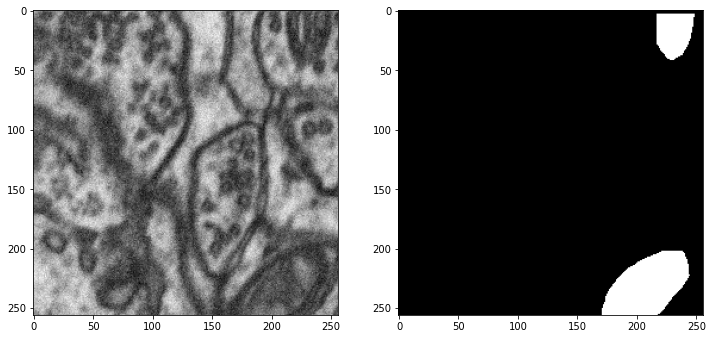

In [9]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [10]:
#Import the U-net model

IMG_HEIGHT = images.shape[1]
IMG_WIDTH  = images.shape[2]
IMG_CHANNELS = images.shape[3]

def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [11]:
#Define generators for data augmentation
#New generator with rotation and shear where interpolation that comes with rotation and shear are thresholded in masks. 
#This gives a binary mask rather than a mask with interpolated values. 
seed=24
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)

In [12]:
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)


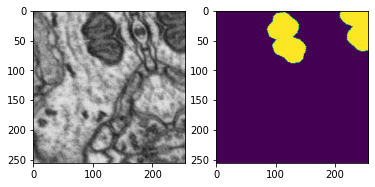

In [16]:
x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

In [18]:
#Train the keras model

batch_size = 16
steps_per_epoch = 3*(len(X_train))//batch_size


history = model.fit(my_generator, validation_data=validation_datagen, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_steps=steps_per_epoch, epochs=50)

Epoch 1/50
20/20 [==============================] - 16s 837ms/step - loss: 0.2544 - accuracy: 0.9164 - val_loss: 0.2440 - val_accuracy: 0.9238
Epoch 2/50
20/20 [==============================] - 13s 648ms/step - loss: 0.2556 - accuracy: 0.9155 - val_loss: 0.2505 - val_accuracy: 0.9217
Epoch 3/50
20/20 [==============================] - 12s 634ms/step - loss: 0.2572 - accuracy: 0.9119 - val_loss: 0.2730 - val_accuracy: 0.9175
Epoch 4/50
20/20 [==============================] - 12s 632ms/step - loss: 0.2566 - accuracy: 0.9151 - val_loss: 0.2741 - val_accuracy: 0.9183
Epoch 5/50
20/20 [==============================] - 12s 634ms/step - loss: 0.2507 - accuracy: 0.9136 - val_loss: 0.2671 - val_accuracy: 0.9174
Epoch 6/50
20/20 [==============================] - 12s 618ms/step - loss: 0.2253 - accuracy: 0.9131 - val_loss: 0.4558 - val_accuracy: 0.9164
Epoch 7/50
20/20 [==============================] - 11s 542ms/step - loss: 0.1871 - accuracy: 0.9191 - val_loss: 0.6320 - val_accuracy: 0.6470

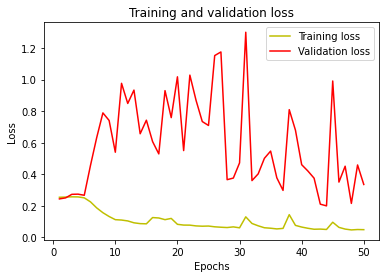

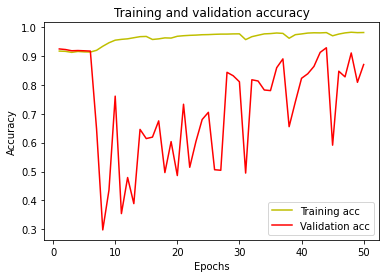

In [19]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)


model.save('mito_model_50epochs.h5')  #Save the keras model

2/2 [==============================] - 1s 97ms/step
IoU socre is:  0.5238087968122624


In [21]:
#Segmentation using the saved keras model

#Load The saved keras model 
from tensorflow.keras.models import load_model
loaded_keras_model = load_model('mito_model_50epochs.h5', compile=False)


1/1 [==============================] - 0s 20ms/step


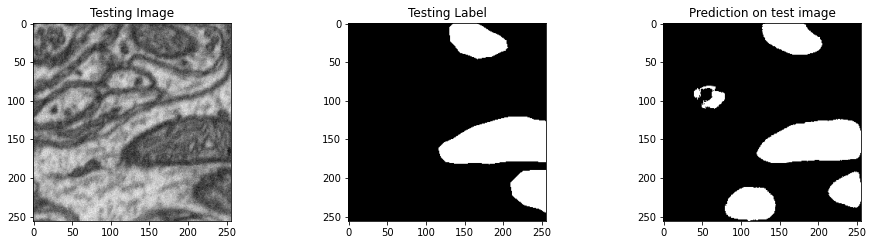

In [26]:
#Predict on a few images
#model = get_model()
#model.load_weights('mitochondria_50_plus_100_epochs.hdf5') #Trained for 50 epochs and then additional 100

test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (loaded_keras_model.predict(test_img_input)[0,:,:,0] > 0.7).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [32]:
#Convert the keras model into onnx format and save the ONNX file
"""
Command line..
python -m tf2onnx.convert --saved-model tensorflow-model-path --output model.onnx
"""

import tf2onnx.convert
import onnx

#Load The saved model 
loaded_keras_model = load_model('mito_model_50epochs.h5')


onnx_model, _ = tf2onnx.convert.from_keras(loaded_keras_model)
onnx.save(onnx_model, 'onnx_model_50epochs.onnx')


1/1 [==============================] - 0s 22ms/step


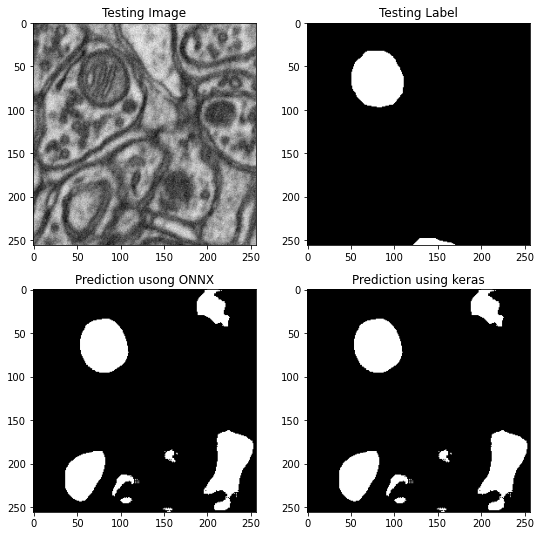

In [36]:
# Segment images using the saved ONNX model

import onnxruntime

session = onnxruntime.InferenceSession("onnx_model_50epochs.onnx")
session.get_inputs()[0].shape
session.get_inputs()[0].type

input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)


result = session.run([output_name], {input_name: test_img_input})

segmented = (result[0][0,:,:,0] >0.5).astype(np.uint8)

keras_prediction = (loaded_keras_model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(9, 9))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(222)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(223)
plt.title('Prediction usong ONNX')
plt.imshow(segmented, cmap='gray')
plt.subplot(224)
plt.title('Prediction using keras')
plt.imshow(keras_prediction, cmap='gray')

plt.show()